# Data Deduplication using Clustering
**Objective**: Learn and implement data deduplication techniques.

**Task**: DBSCAN for Data Deduplication

**Steps**:
1. Data Set: Download a dataset containing duplicate entries for event registrations.
2. DBSCAN Clustering: Apply the DBSCAN algorithm to cluster similar registrations.
3. Identify Duplicates: Detect duplicates based on density of the clusters.
4. Refinement: Validate clusters and remove any erroneous duplicates.

Initial DataFrame shape: (815, 7)
Sample of initial DataFrame:
   Registration_ID Participant_Name  Registration_Time_Seconds  \
0              196        Eve Adams              277602.965130   
1              299         Ivy King              267343.764401   
2              388        Eve Adams               93873.559314   
3              227     Grace Taylor              107800.848409   
4              664     Grace Taylor              361116.464818   

   Payment_Amount  Tickets_Purchased  Event_Type             Registration_Time  
0          320.27                  4     Seminar 2025-01-04 14:06:42.965130459  
1          300.49                  1     Webinar 2025-01-04 11:15:43.764401312  
2           78.40                  3     Webinar 2025-01-02 11:04:33.559314262  
3          296.82                  4  Conference 2025-01-02 14:56:40.848408512  
4          231.05                  1  Conference 2025-01-05 13:18:36.464817966  

Sample of Scaled Data (used for DBSCAN):
   Registrat

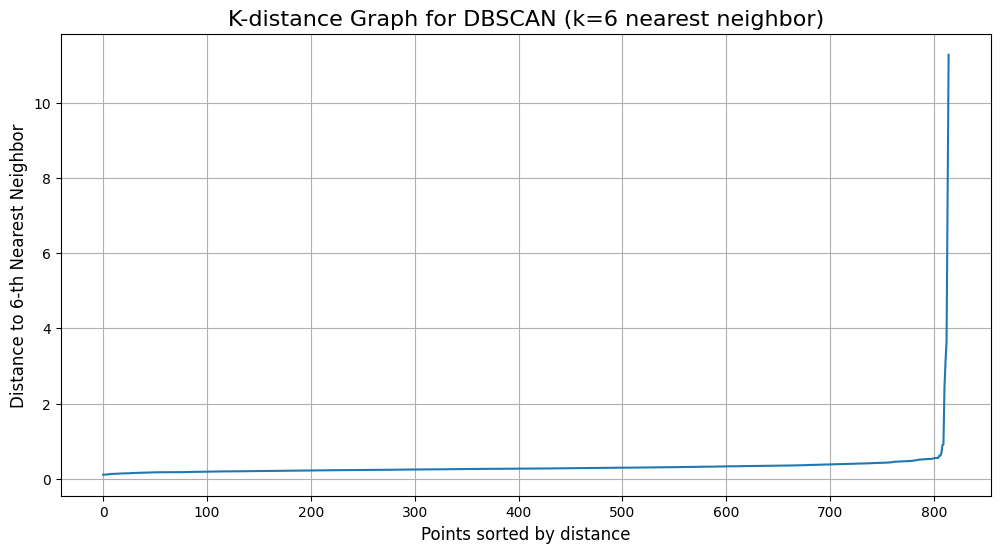


Applying DBSCAN with chosen eps=0.5 and min_samples=6

DataFrame with DBSCAN Cluster Assignments (first 10 rows):
   Registration_ID Participant_Name  Registration_Time_Seconds  \
0              196        Eve Adams              277602.965130   
1              299         Ivy King              267343.764401   
2              388        Eve Adams               93873.559314   
3              227     Grace Taylor              107800.848409   
4              664     Grace Taylor              361116.464818   
5              786         Ivy King               42661.617691   
6              199      Frank White              281699.728143   
7              336      Bob Johnson               32544.725597   
8              338     Harry Wilson              275522.687181   
9              528       Jack Green              150351.640518   

   Payment_Amount  Tickets_Purchased  Event_Type  \
0          320.27                  4     Seminar   
1          300.49                  1     Webinar   
2 

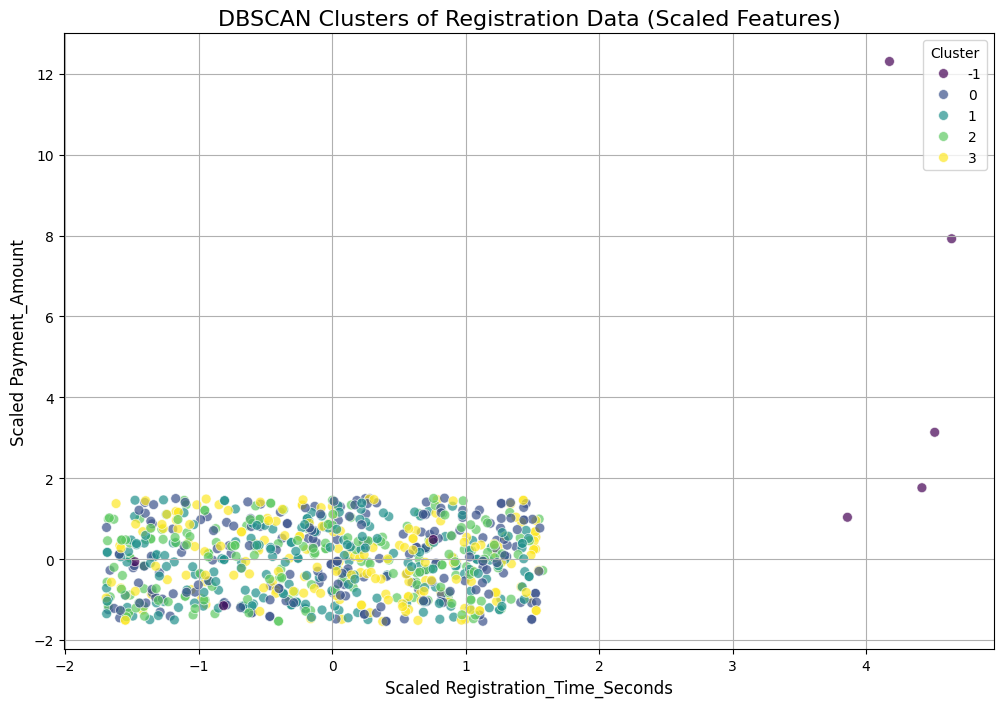

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score # Added for evaluation, though not directly for deduplication decision
from scipy.spatial.distance import pdist, squareform # For density-based epsilon selection

# Set random seed for reproducibility
np.random.seed(42)

# --- 1. Data Set: Generate Synthetic Event Registration Data with Duplicates ---
# More complex data generation to include names with potential typos
def generate_registration_data_enhanced(num_records=1000, num_exact_dups=100, num_near_dups=50, num_outliers=10):
    start_time = pd.to_datetime('2025-01-01 09:00:00')
    time_range_seconds = (pd.to_datetime('2025-01-05 17:00:00') - start_time).total_seconds()

    base_names = ['Alice Smith', 'Bob Johnson', 'Charlie Brown', 'Diana Prince', 'Eve Adams',
                  'Frank White', 'Grace Taylor', 'Harry Wilson', 'Ivy King', 'Jack Green']
    
    data = {
        'Registration_ID': range(num_records),
        'Participant_Name': np.random.choice(base_names, num_records),
        'Registration_Time_Seconds': np.random.uniform(0, time_range_seconds, num_records),
        'Payment_Amount': np.random.uniform(50, 500, num_records).round(2),
        'Tickets_Purchased': np.random.randint(1, 5, num_records),
        'Event_Type': np.random.choice(['Conference', 'Workshop', 'Seminar', 'Webinar'], num_records)
    }
    df = pd.DataFrame(data)

    df['Registration_Time'] = pd.to_datetime(start_time + pd.to_timedelta(df['Registration_Time_Seconds'], unit='s'))

    # Introduce exact duplicates
    exact_duplicate_rows = df.sample(n=num_exact_dups, replace=False, random_state=42).copy()
    exact_duplicate_rows['Registration_ID'] = np.random.randint(num_records, num_records + num_exact_dups, num_exact_dups)
    df = pd.concat([df, exact_duplicate_rows], ignore_index=True)

    # Introduce near-duplicates (slight variations + name typos)
    near_duplicate_rows = df.sample(n=num_near_dups, replace=False, random_state=100).copy()
    near_duplicate_rows['Registration_ID'] = np.random.randint(num_records + num_exact_dups, num_records + num_exact_dups + num_near_dups, num_near_dups)
    near_duplicate_rows['Payment_Amount'] = near_duplicate_rows['Payment_Amount'] + np.random.uniform(-5, 5, num_near_dups).round(2)
    near_duplicate_rows['Registration_Time_Seconds'] = near_duplicate_rows['Registration_Time_Seconds'] + np.random.uniform(-3600, 3600, num_near_dups)
    near_duplicate_rows['Tickets_Purchased'] = np.clip(near_duplicate_rows['Tickets_Purchased'] + np.random.randint(-1, 2, num_near_dups), 1, 5)
    near_duplicate_rows['Registration_Time'] = pd.to_datetime(start_time + pd.to_timedelta(near_duplicate_rows['Registration_Time_Seconds'], unit='s'))

    # Introduce typos in Participant_Name for near-duplicates
    for i in range(len(near_duplicate_rows)):
        name = list(near_duplicate_rows.iloc[i]['Participant_Name'])
        if len(name) > 3 and np.random.rand() < 0.3: # 30% chance of typo
            idx_to_change = np.random.randint(0, len(name))
            name[idx_to_change] = chr(ord(name[idx_to_change]) + np.random.choice([-1, 1])) # Simple char change
        near_duplicate_rows.iloc[i, near_duplicate_rows.columns.get_loc('Participant_Name')] = "".join(name)

    df = pd.concat([df, near_duplicate_rows], ignore_index=True)

    # Introduce some clear outliers
    outlier_rows = df.sample(n=num_outliers, replace=False, random_state=200).copy()
    outlier_rows['Registration_ID'] = np.random.randint(num_records + num_exact_dups + num_near_dups, num_records + num_exact_dups + num_near_dups + num_outliers, num_outliers)
    outlier_rows['Payment_Amount'] = outlier_rows['Payment_Amount'] * np.random.uniform(5, 10, num_outliers)
    outlier_rows['Registration_Time_Seconds'] = np.random.uniform(time_range_seconds * 1.5, time_range_seconds * 2, num_outliers)
    outlier_rows['Registration_Time'] = pd.to_datetime(start_time + pd.to_timedelta(outlier_rows['Registration_Time_Seconds'], unit='s'))
    df = pd.concat([df, outlier_rows], ignore_index=True)

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

# Generate data
registration_df = generate_registration_data_enhanced(num_records=700, num_exact_dups=70, num_near_dups=40, num_outliers=5)
print(f"Initial DataFrame shape: {registration_df.shape}")
print("Sample of initial DataFrame:")
print(registration_df.head())

# Features for clustering (numerical features are key for DBSCAN direct application)
# For 'Event_Type', if needed for clustering, one-hot encoding would be used.
# For 'Participant_Name', string similarity (fuzzy matching) is usually applied POST-clustering
# or via text embeddings if clustering directly on name similarity.
numerical_features = ['Registration_Time_Seconds', 'Payment_Amount', 'Tickets_Purchased']
X_numerical = registration_df[numerical_features]

# --- 2. Preprocess: Standardize the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_features, index=registration_df.index)

print("\nSample of Scaled Data (used for DBSCAN):")
print(X_scaled_df.head())

# --- 3. DBSCAN Clustering: Apply the algorithm ---

# Determine min_samples: A common heuristic is 2 * number_of_features.
# For noisy datasets or higher dimensions, values like 2*D or 2*D+1 are often used.
min_samples_val = 2 * len(numerical_features)
print(f"\nUsing min_samples = 2 * features = {min_samples_val}")

# Determine eps: Using the K-distance Graph (Elbow Method)
# This plots the distance to the k-th (min_samples) nearest neighbor for each point.
# An "elbow" indicates a good eps value.
neigh = NearestNeighbors(n_neighbors=min_samples_val)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
# Sort distances to the (min_samples-1)-th (k-th) neighbor
distances = np.sort(distances[:, min_samples_val-1], axis=0)

plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title(f'K-distance Graph for DBSCAN (k={min_samples_val} nearest neighbor)', fontsize=16)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'Distance to {min_samples_val}-th Nearest Neighbor', fontsize=12)
plt.grid(True)
plt.show()

# Based on the elbow plot, manually choose an appropriate 'eps' value.
# For deduplication, 'eps' needs to be very small to form tight clusters of duplicates.
# A small value (e.g., 0.1 to 1.0 for scaled data) is typical.
# You would pick the point right before the steep increase (the 'elbow').
chosen_eps = 0.5 # **CRITICAL: ADJUST THIS VALUE BASED ON YOUR K-DISTANCE PLOT'S ELBOW**

print(f"\nApplying DBSCAN with chosen eps={chosen_eps} and min_samples={min_samples_val}")
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples_val)
registration_df['Cluster'] = dbscan.fit_predict(X_scaled)

print("\nDataFrame with DBSCAN Cluster Assignments (first 10 rows):")
print(registration_df.head(10))
print(f"\nCluster distribution (value counts, top 10):")
print(registration_df['Cluster'].value_counts().head(10))
print(f"Total number of clusters formed (excluding noise -1): {registration_df['Cluster'].nunique() - (1 if -1 in registration_df['Cluster'].values else 0)}")
print(f"Number of noise points (cluster -1): {(registration_df['Cluster'] == -1).sum()}")

# --- 4. Identify Duplicates and Refinement ---
# Records with Cluster = -1 are noise points (outliers) and are considered unique.
# Records within clusters (Cluster >= 0) with more than one member are potential duplicate groups.

deduplicated_records = []
duplicates_removed_count = 0
retained_original_indices = set() # To prevent adding the same row multiple times if indices overlap

# Group by cluster ID
grouped_by_cluster = registration_df.groupby('Cluster')

for cluster_id, cluster_group in grouped_by_cluster:
    if cluster_id == -1:
        # Noise points are considered unique
        for idx, row in cluster_group.iterrows():
            if idx not in retained_original_indices:
                deduplicated_records.append(row)
                retained_original_indices.add(idx)
    else:
        # For non-noise clusters, identify duplicates within them
        if len(cluster_group) > 1: # Only proceed if the cluster has multiple members
            # For numerical features, group by exact matches to confirm duplicates.
            # For 'Participant_Name', one might apply fuzzy string matching here
            # (e.g., check Jaro-Winkler similarity > 0.85).
            
            # Create a hashable tuple of the numerical features for grouping exact duplicates
            cluster_group['features_tuple'] = list(zip(*[cluster_group[col] for col in numerical_features]))
            
            # Group by this hashable tuple to find truly identical numerical records within the cluster
            sub_grouped_by_exact_features = cluster_group.groupby('features_tuple')

            for _, sub_group in sub_grouped_by_exact_features:
                if len(sub_group) > 1:
                    # These are multiple records in the same exact numerical feature space within this cluster.
                    # They are strong candidates for duplicates.
                    duplicates_removed_count += (len(sub_group) - 1)
                    # Keep the first record of this exact group as the representative
                    if sub_group.iloc[0].name not in retained_original_indices:
                        deduplicated_records.append(sub_group.iloc[0])
                        retained_original_indices.add(sub_group.iloc[0].name)
                else:
                    # This record is numerically unique within its cluster, but still part of a dense cluster.
                    # It's kept as a unique entity.
                    if sub_group.iloc[0].name not in retained_original_indices:
                        deduplicated_records.append(sub_group.iloc[0])
                        retained_original_indices.add(sub_group.iloc[0].name)
        else:
            # Cluster has only one member (it's unique by DBSCAN's density definition)
            if cluster_group.iloc[0].name not in retained_original_indices:
                deduplicated_records.append(cluster_group.iloc[0])
                retained_original_indices.add(cluster_group.iloc[0].name)

# Create the final deduplicated DataFrame
# Drop the temporary 'Cluster' and 'features_tuple' columns
final_df = pd.DataFrame(deduplicated_records).drop(columns=['Cluster', 'features_tuple'], errors='ignore')

print(f"\nTotal potential duplicates identified and removed: {duplicates_removed_count}")
print(f"Original DataFrame size: {len(registration_df)}")
print(f"Deduplicated DataFrame size: {len(final_df)}")
print("\nSample of Deduplicated DataFrame:")
print(final_df.head())

# --- Verification ---
print("\n--- Verification of Deduplication Impact ---")
# Check exact duplicates based on numerical features before and after
num_exact_dups_before = registration_df.duplicated(subset=numerical_features).sum()
print(f"Number of exact duplicates (on numerical features) before DBSCAN processing: {num_exact_dups_before}")

num_exact_dups_after = final_df.duplicated(subset=numerical_features).sum()
print(f"Number of exact duplicates (on numerical features) after DBSCAN deduplication: {num_exact_dups_after}")

# Compare total unique records
num_unique_records_original = registration_df.drop_duplicates(subset=numerical_features).shape[0]
print(f"Number of truly unique records (numerical features) in original DF: {num_unique_records_original}")
print(f"Number of records in final (deduplicated) DF: {len(final_df)}")

if num_exact_dups_after == 0:
    print("\nSuccess: No exact duplicates (on numerical features) remaining in the deduplicated DataFrame.")
else:
    print("\nWarning: Some exact duplicates (on numerical features) might still remain. Adjust DBSCAN 'eps'/'min_samples' or refine intra-cluster deduplication logic.")

# Optional: Visualize clusters (if 2D or 3D)
# If you have more than 2-3 numerical features, direct scatter plot isn't helpful.
# Consider using PCA/t-SNE for dimensionality reduction before visualizing high-dim data.
if len(numerical_features) >= 2:
    plt.figure(figsize=(12, 8))
    # Plotting only the first two scaled features for visualization
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=registration_df['Cluster'],
                    palette='viridis', legend='full', s=50, alpha=0.7)
    plt.title('DBSCAN Clusters of Registration Data (Scaled Features)', fontsize=16)
    plt.xlabel(f'Scaled {numerical_features[0]}', fontsize=12)
    plt.ylabel(f'Scaled {numerical_features[1]}', fontsize=12)
    plt.grid(True)
    plt.show()